In [38]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve,
from sklearn.ensemble import RandomForestClassifier
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [14]:
train_df = pd.read_csv("data/twitter_data_train.csv")
test_df = pd.read_csv("data/twitter_data_test.csv")

print(train_df.shape)
print(test_df.shape)

(9445, 233)
(1667, 233)


In [17]:
to_drop = [
    'account_type', 
    'id', 
    'name', 
    'screen_name',
    'profile_image_url',
    'protected',
    'verified',
    'description',
    'description_processed',
    'tweets_list',
    'tweets_list_processed',
    'url'
    ]

X_train, y_train = train_df.drop(to_drop, axis=1), train_df['account_type']
X_test, y_test = test_df.drop(to_drop, axis=1), test_df['account_type']

# X_train.fillna(0, inplace=True)
# X_test.fillna(0, inplace=True)


**Random Forest model training and testing**

In [36]:
# Random forest model 
# training
regressor = RandomForestClassifier(n_estimators=100)
regressor.fit(X_train, y_train)

RandomForestClassifier()

**Evaluate Model Performance**

In [56]:
# train
y_pred_train = regressor.predict(X_train)
print(classification_report(y_train, y_pred_train, digits=5))
roc_auc_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      7004
           1    1.00000   1.00000   1.00000      2441

    accuracy                        1.00000      9445
   macro avg    1.00000   1.00000   1.00000      9445
weighted avg    1.00000   1.00000   1.00000      9445



1.0

In [57]:
# test
y_pred_test = regressor.predict(X_test)
print(classification_report(y_test, y_pred_test, digits=5))
roc_auc_score(y_test, y_pred_test)

              precision    recall  f1-score   support

           0    0.99268   0.98947   0.99107      1234
           1    0.97025   0.97921   0.97471       433

    accuracy                        0.98680      1667
   macro avg    0.98147   0.98434   0.98289      1667
weighted avg    0.98686   0.98680   0.98682      1667



0.9843399672856442

**Hyperparameter Tuning**

We will use RandomizedSearchCV to narrow down the range for grid search hyperparameter tuning.


In [21]:
regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [24]:
# Random forest model 
# training
regressor = RandomForestClassifier()

rf_randomcv = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=grid,
    n_iter=50, 
    cv=3, # k-fold cv
    # verbose=2,
    random_state=2022,
    n_jobs=-1 # use all processors
)

rf_randomcv.fit(X_train, y_train)


c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=2022)

In [25]:
rf_randomcv.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [26]:
rf_randomcv.best_score_

0.9914241681909197

**Hyperparameter Tuning**

We will use GridSearchCV for hyperparameter tuning.


In [28]:

n_estimators = [500, 1000, 1500, 2000]
max_features = ['auto']
max_depth = [30, 40, 50,60,70]
min_samples_split = [1,2,3]
min_samples_leaf = [1, 2, 3]
bootstrap = [False]

narrow_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(narrow_grid)

{'n_estimators': [500, 1000, 1500, 2000], 'max_features': ['auto'], 'max_depth': [30, 40, 50, 60, 70], 'min_samples_split': [1, 2, 3], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [False]}


In [29]:
regressor = RandomForestClassifier()

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=2022)

rf_gridcv = GridSearchCV(
    estimator=regressor,
    param_grid=narrow_grid,
    cv= cv_method, # k-fold cv
    verbose=2,
    n_jobs=-1 # use all processors
)

rf_gridcv.fit(X_train, y_train)

Fitting 15 folds for each of 180 candidates, totalling 2700 fits


c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
900 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=2022),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [30, 40, 50, 60, 70],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [500, 1000, 1500, 2000]},
             verbose=2)

In [30]:
rf_gridcv.best_params_

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [31]:
rf_gridcv.best_score_

0.9918828304217399

**Use tuned classifier**

In [ ]:
best_clf = rf_gridcv.best_estimator_

In [58]:
# train
y_pred_train_tuned = best_clf.predict(X_train)
print(classification_report(y_train, y_pred_train_tuned, digits=5))
roc_auc_score(y_train, y_pred_train_tuned)

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      7004
           1    1.00000   1.00000   1.00000      2441

    accuracy                        1.00000      9445
   macro avg    1.00000   1.00000   1.00000      9445
weighted avg    1.00000   1.00000   1.00000      9445



1.0

In [59]:
# test
y_pred_test_tuned = best_clf.predict(X_test)
print(classification_report(y_test, y_pred_test_tuned, digits=5))
roc_auc_score(y_test, y_pred_test_tuned)

              precision    recall  f1-score   support

           0    0.99592   0.98865   0.99227      1234
           1    0.96833   0.98845   0.97829       433

    accuracy                        0.98860      1667
   macro avg    0.98212   0.98855   0.98528      1667
weighted avg    0.98875   0.98860   0.98864      1667



0.9885537185442487

ROC Curves for classifier before and after tuning

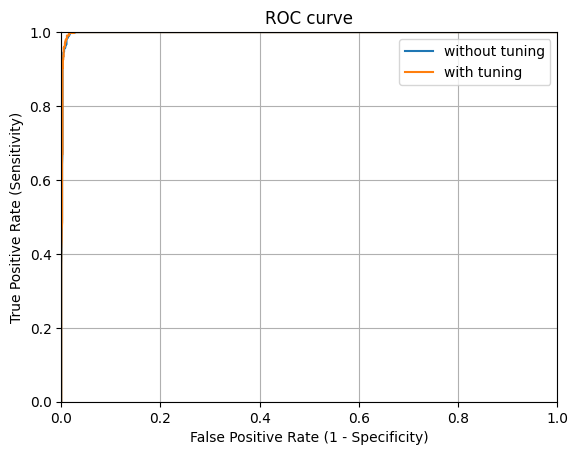

In [37]:
y_pred_prob1 = regressor.predict_proba(X_test)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob1)
y_pred_prob2 = best_clf.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob2)

plt.plot(fpr1, tpr1, label = "without tuning")
plt.plot(fpr2, tpr2, label ="with tuning")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

Visualising some of the trees in the random forest

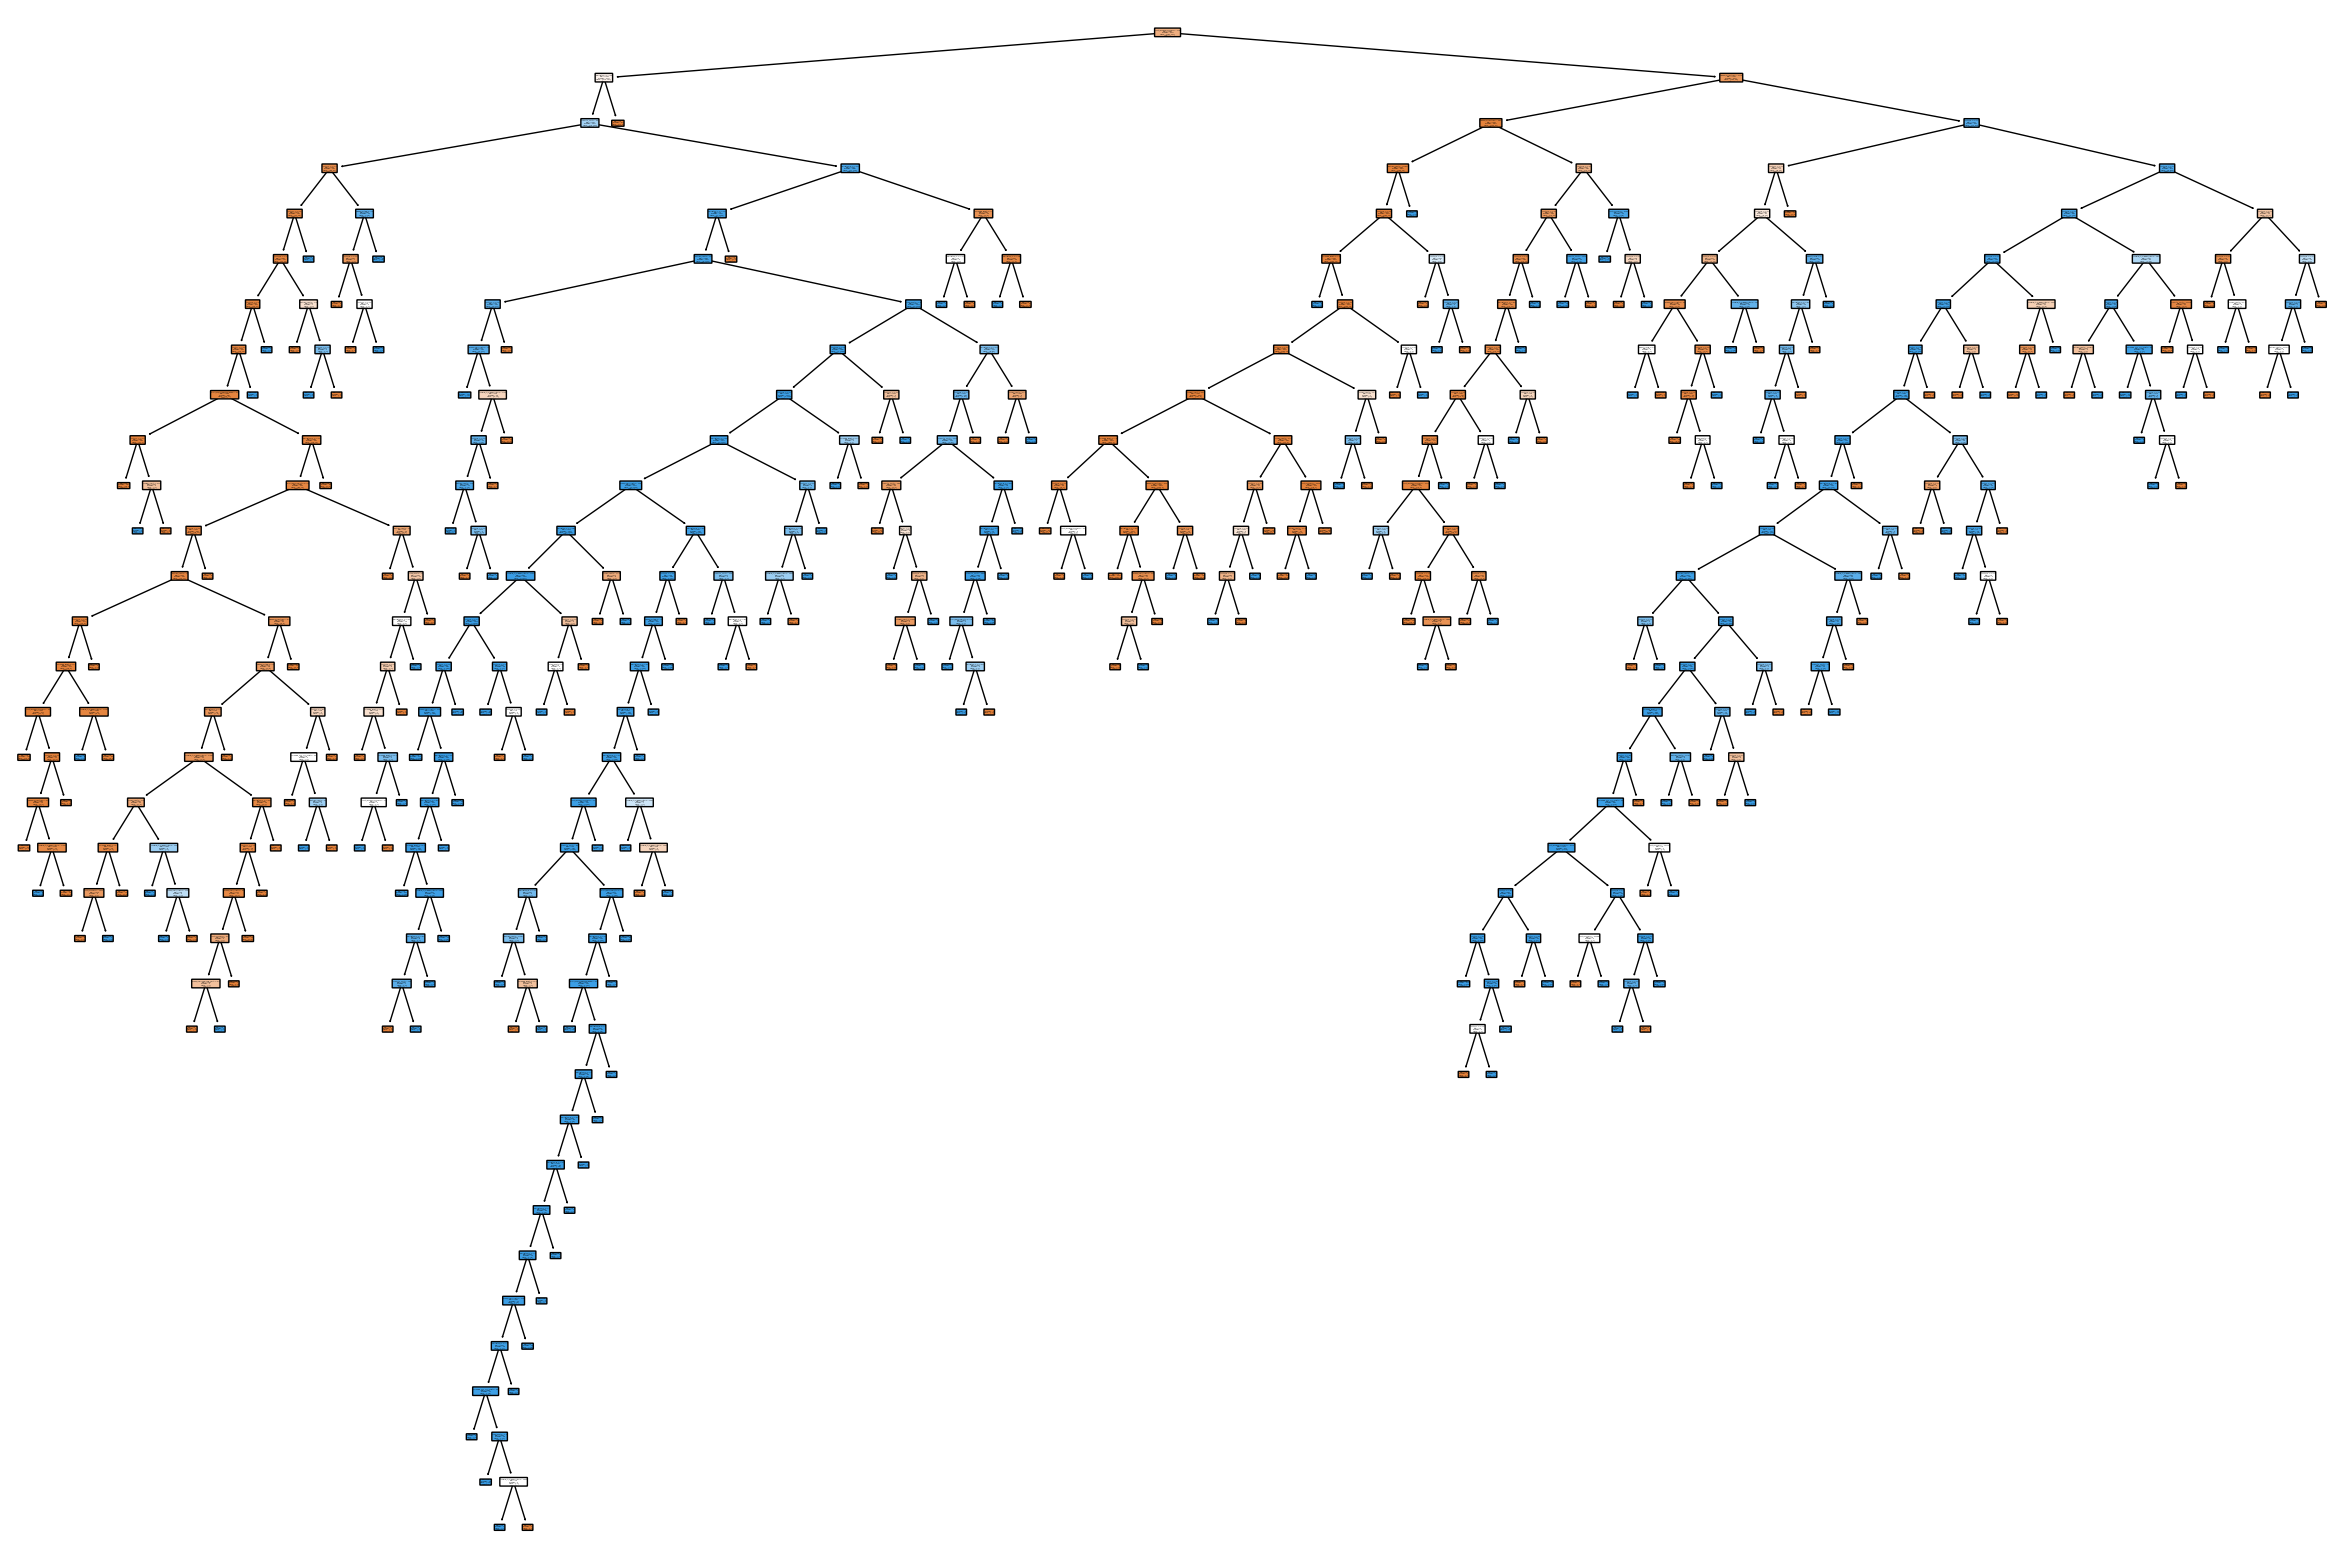

In [50]:

fig = plt.figure(figsize=(30, 20))
plot_tree(best_clf.estimators_[0], 
          feature_names=X_train.columns,
          class_names=["0","1"], 
          filled=True, rounded=True)

plt.show()

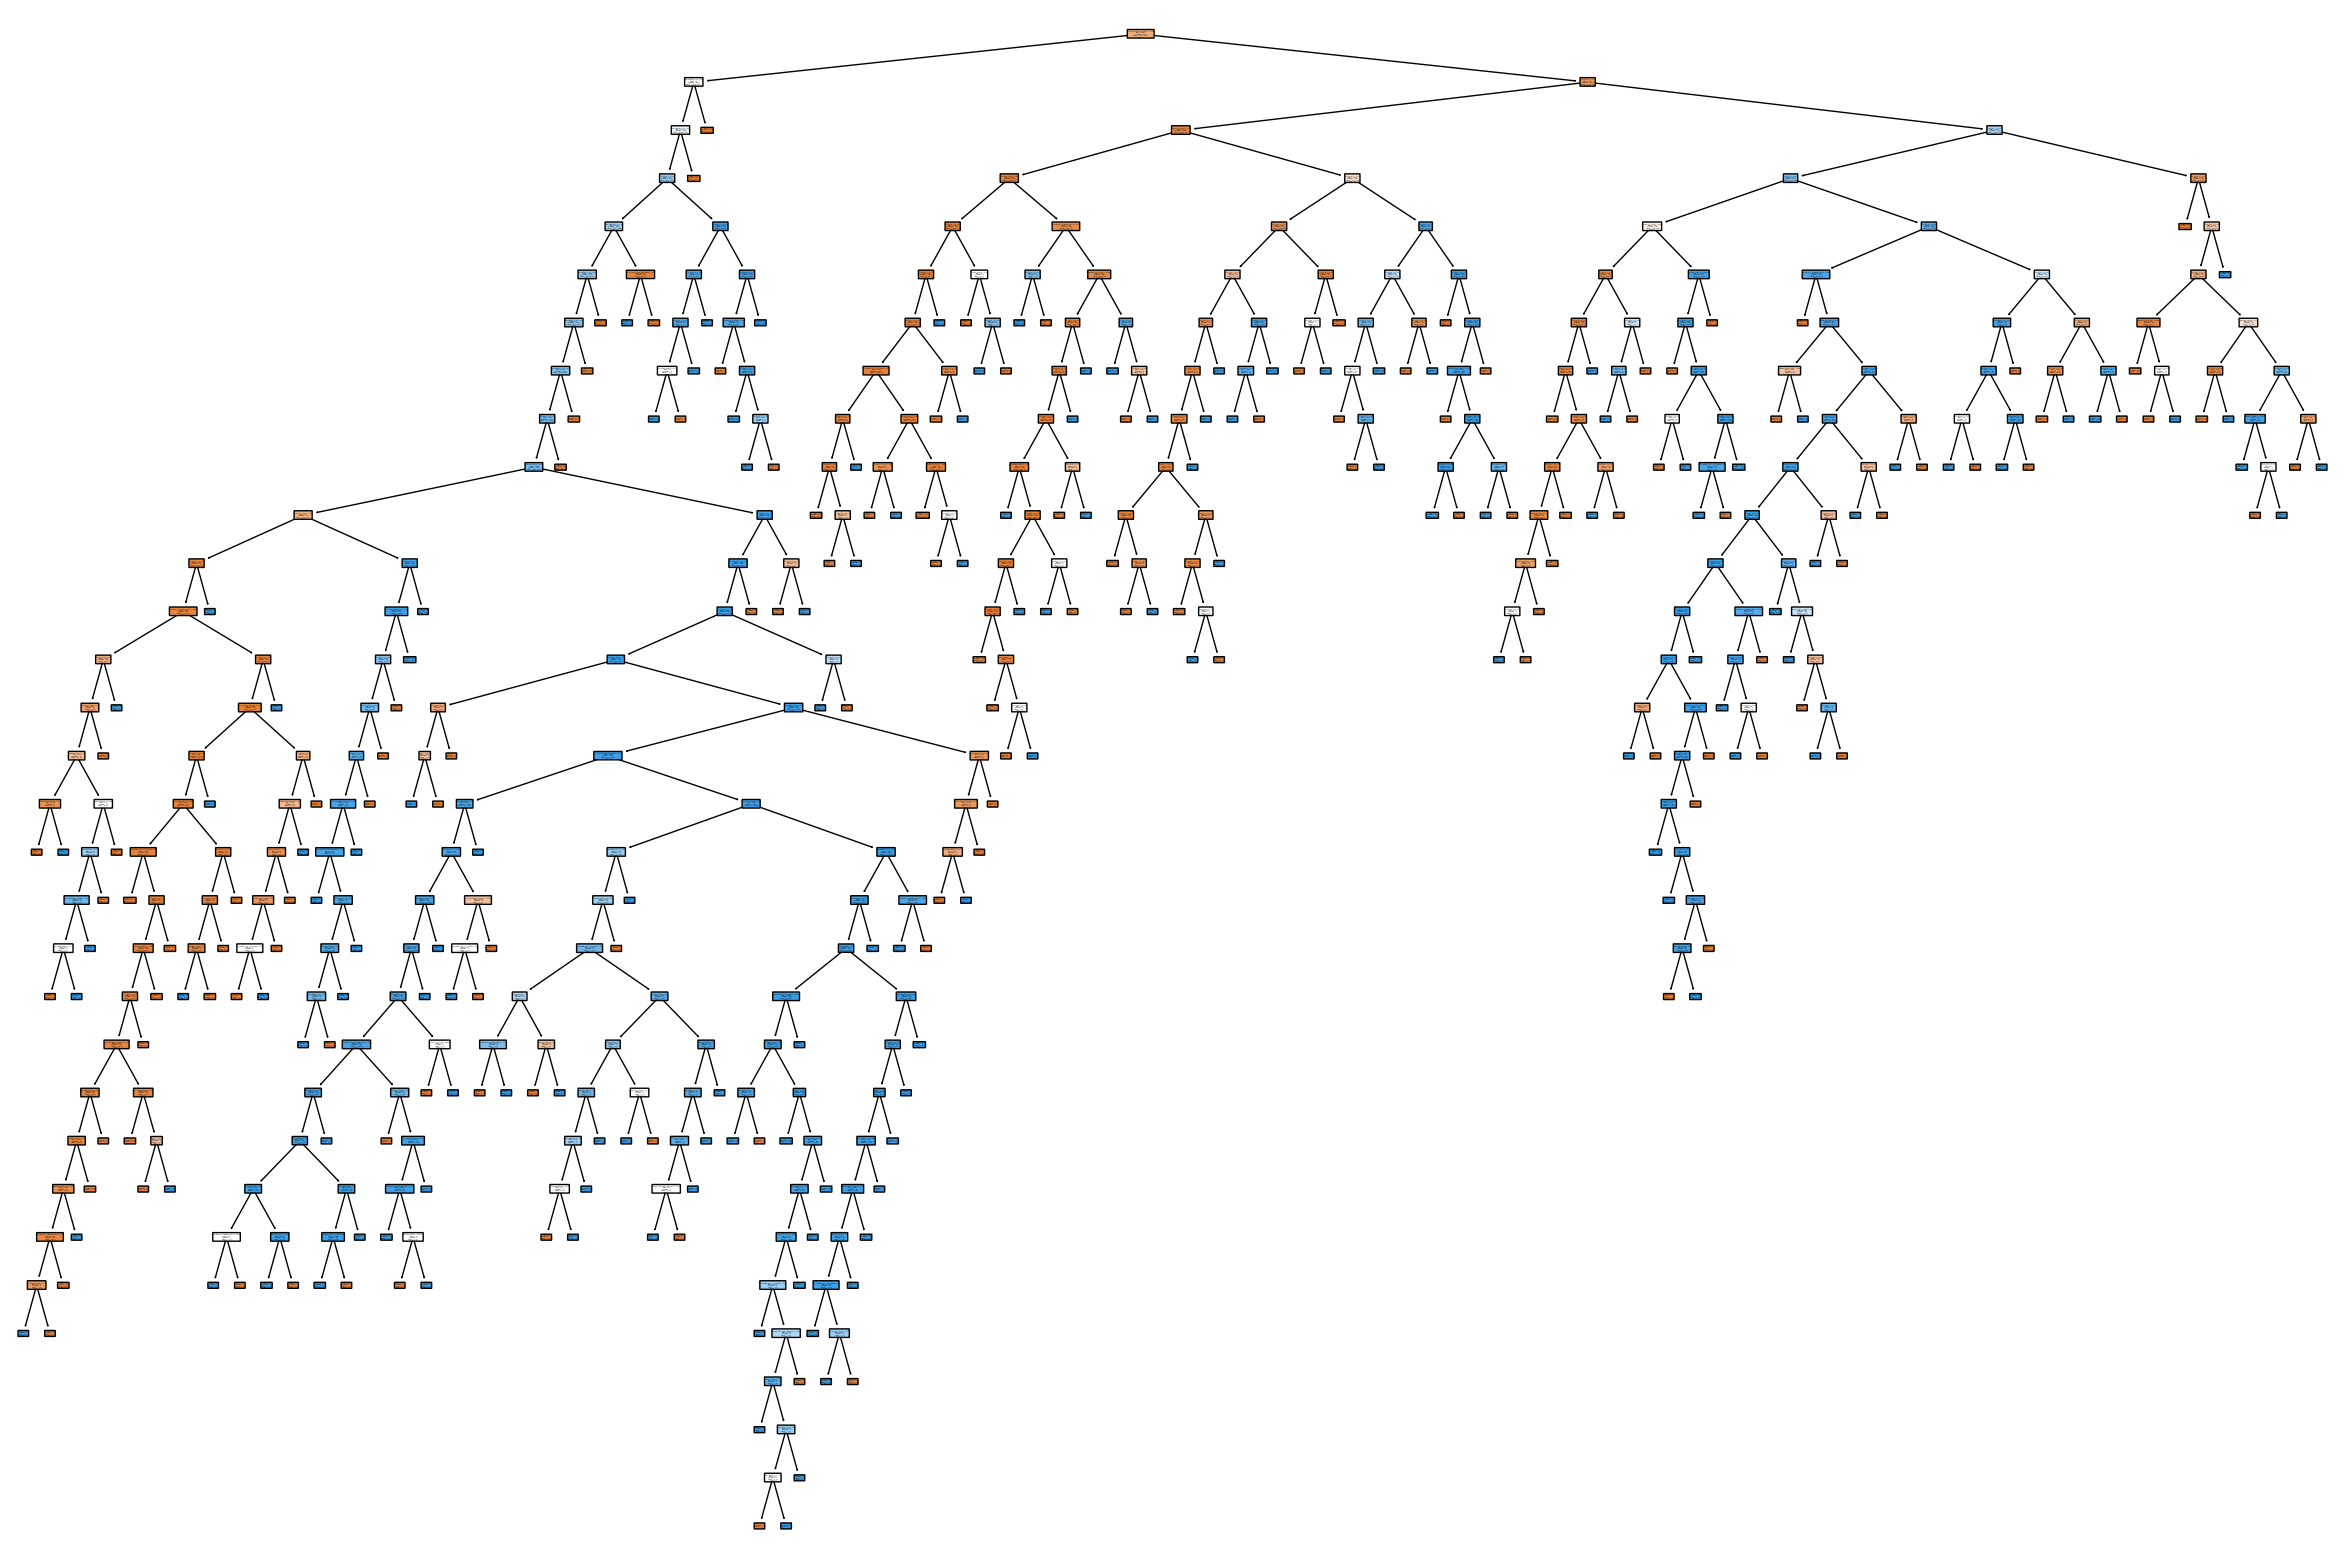

In [ ]:

fig = plt.figure(figsize=(30, 20))
plot_tree(best_clf.estimators_[1], 
          feature_names=X_train.columns,
          class_names=["0","1"], 
          filled=True, rounded=True)

plt.show()